# ECG Anomaly Detection

## Project Goal

To successfully identify abnormal ECG's by training a machine learning model to recognize normal ECG's and calculate a threshold.  If the reconstruction error is below the threshold, it will be a normal heartbeat; anything above the threshold will be an anomaly.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pylab import rcParams

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
whimsy_pallette = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(whimsy_pallette))
rcParams['figure.figsize'] = 12, 8

### The Dataset

From [timeseriesclassification.com...](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation. The dataset is stationary.

In [2]:
PATH_TO_DATA = 'data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818287 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490658 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

You can see by scrolling to the last column that it contains the labels - 0 is an anomalous heartbeat, 1 is a normal heartbeat.

In [3]:
data.shape

(4998, 141)

### Drop target from data; create target df with labels

In [4]:
raw_data = data.values

# The last element contains the labels
target = raw_data[:, -1]

# The other data points are the electrocadriogram data
features = raw_data[:, 0:-1]



### Train Test Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=21
)

### Scale the input

In [6]:
min_val = tf.reduce_min(x_train)
max_val = tf.reduce_max(x_train)

x_train = (x_train - min_val) / (max_val - min_val)
x_test = (x_test - min_val) / (max_val - min_val)

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

### Seperate the normal and anomalous ECGs

In [7]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

x_norm_train = x_train[y_train]
x_norm_test = x_test[y_test]

x_abnorm_train = x_train[~y_train]
x_abnorm_test = x_test[~y_test]

### Plot a normal ECG and abnormal ECG

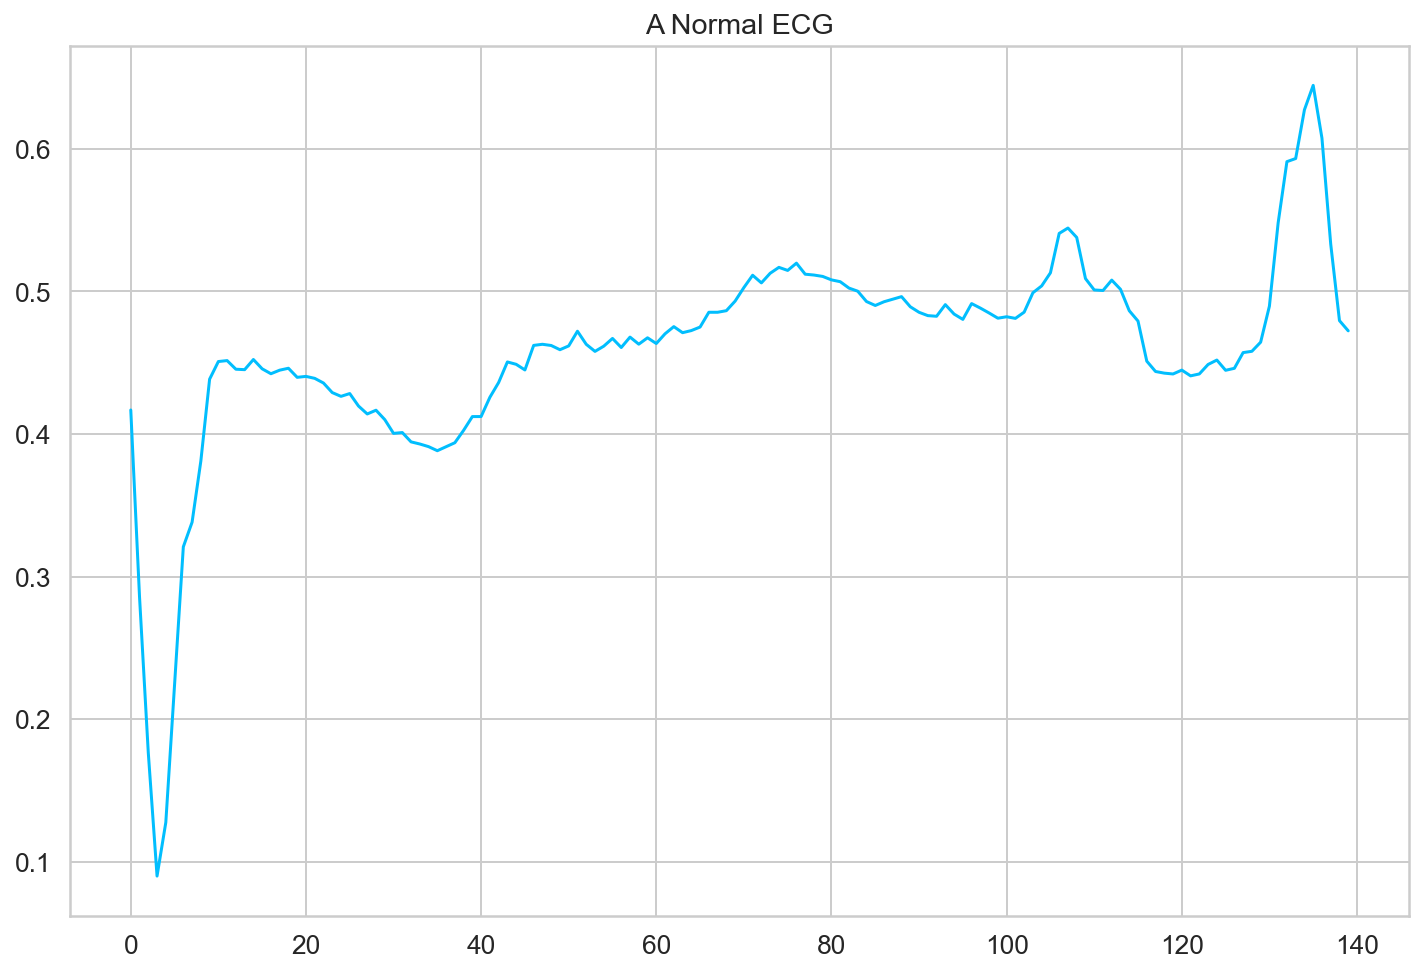

In [8]:
# 1st ECG in the normal set
plt.plot(np.arange(140), x_norm_train[0])
plt.title("A Normal ECG")
plt.savefig('images/normal_ecg.jpg', dpi=300, pad_inches=0.1,)
plt.show()

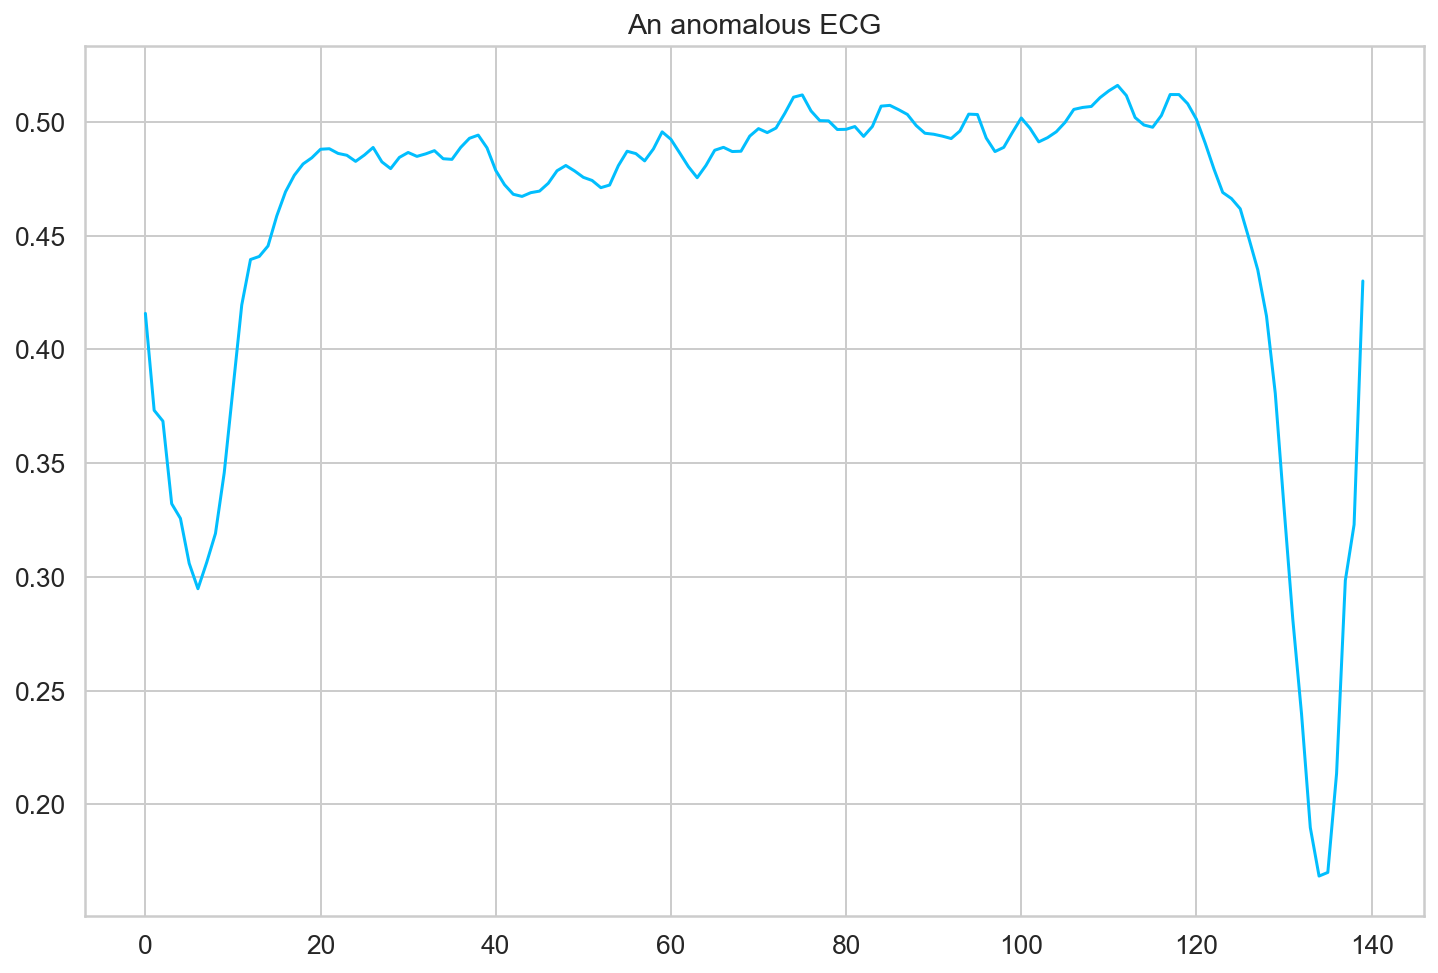

In [9]:
# 1st ECG in the abnormal set
plt.plot(np.arange(140), x_abnorm_train[0])
plt.title("An anomalous ECG")
plt.savefig('images/anomalous_ecg.jpg', dpi=300, pad_inches=0.1,)
plt.show()

## What is an autoencoder
    
An autoencoder is an unsupervised artificial Neural network that attempts to encode the data by compressing it into lower dimensions and the decode the data to reconstruct the original input.  The idea is that the reconstructed data would be as close as possible to the original.  The compressed representation of the input data is called the bottleneck layer.  The number of hidden units in the code is called the code size.  It has several used, one of which is for our purpose, anomaly detection.  Here's a simple diagram:

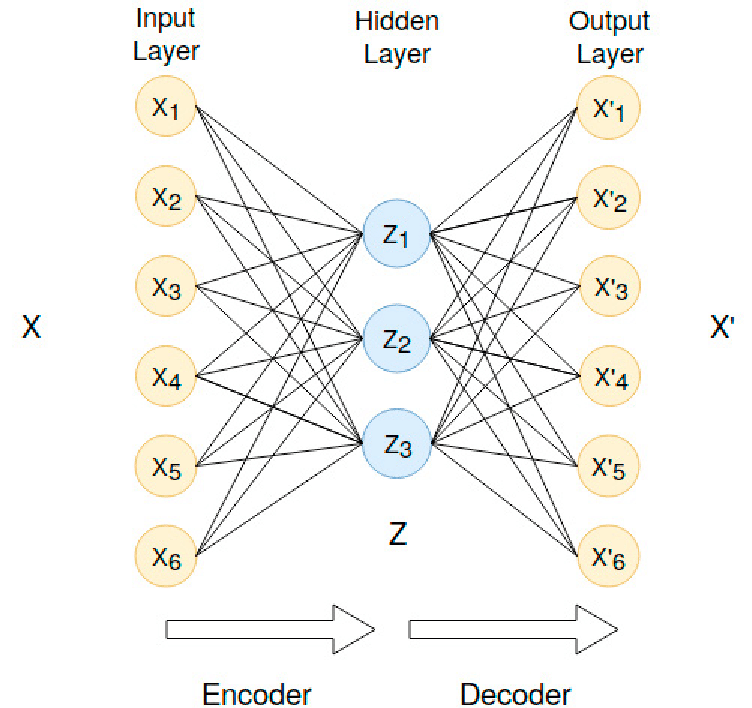



The code size, which is the size of the bottleneck, is the most important hyperperameter.  A small bottleneck lowers the risk of overfittings, but if it's too small,there is an increased chance of important information slipping out through the pooling layers of the encoder.

Autoencoding is essentially a non-linear version of Principal Component Analysis (PCA).  In fact, if you don't define any activations, and set the cost function to mean squared error (MSE), the autoencoder ends up performing PCA.  The initial model below does exactly this:

## Base Model - PCA using an Autoencoder

In [10]:
encoder = Sequential([
      Dense(4),      
      Dense(2),     
    ])
decoder = Sequential([
      Dense(2),     
      Dense(x_norm_train.shape[1])
    ])

In [11]:
autoencoder = keras.models.Sequential([encoder, decoder])

In [12]:
autoencoder.compile(loss='mse', optimizer='adam')

In [13]:
history = autoencoder.fit(
    x_norm_train,
    x_norm_train,
    epochs=50,
    batch_size=256,
    validation_data=(x_test, x_test)
)

Epoch 1/50
9/9 [==============================] - 0s 11ms/step - loss: 0.2186 - val_loss: 0.2053
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1990 - val_loss: 0.1911
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1842 - val_loss: 0.1763
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1688 - val_loss: 0.1608
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1532 - val_loss: 0.1452
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1375 - val_loss: 0.1299
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1224 - val_loss: 0.1155
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1084 - val_loss: 0.1022
Epoch 9/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0954 - val_loss: 0.0900
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0790
Epoch 11/50
9/9 [=====================

In [14]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 574       
_________________________________________________________________
sequential_1 (Sequential)    (None, 140)               426       
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________


### Training vs. Validation loss per epoch

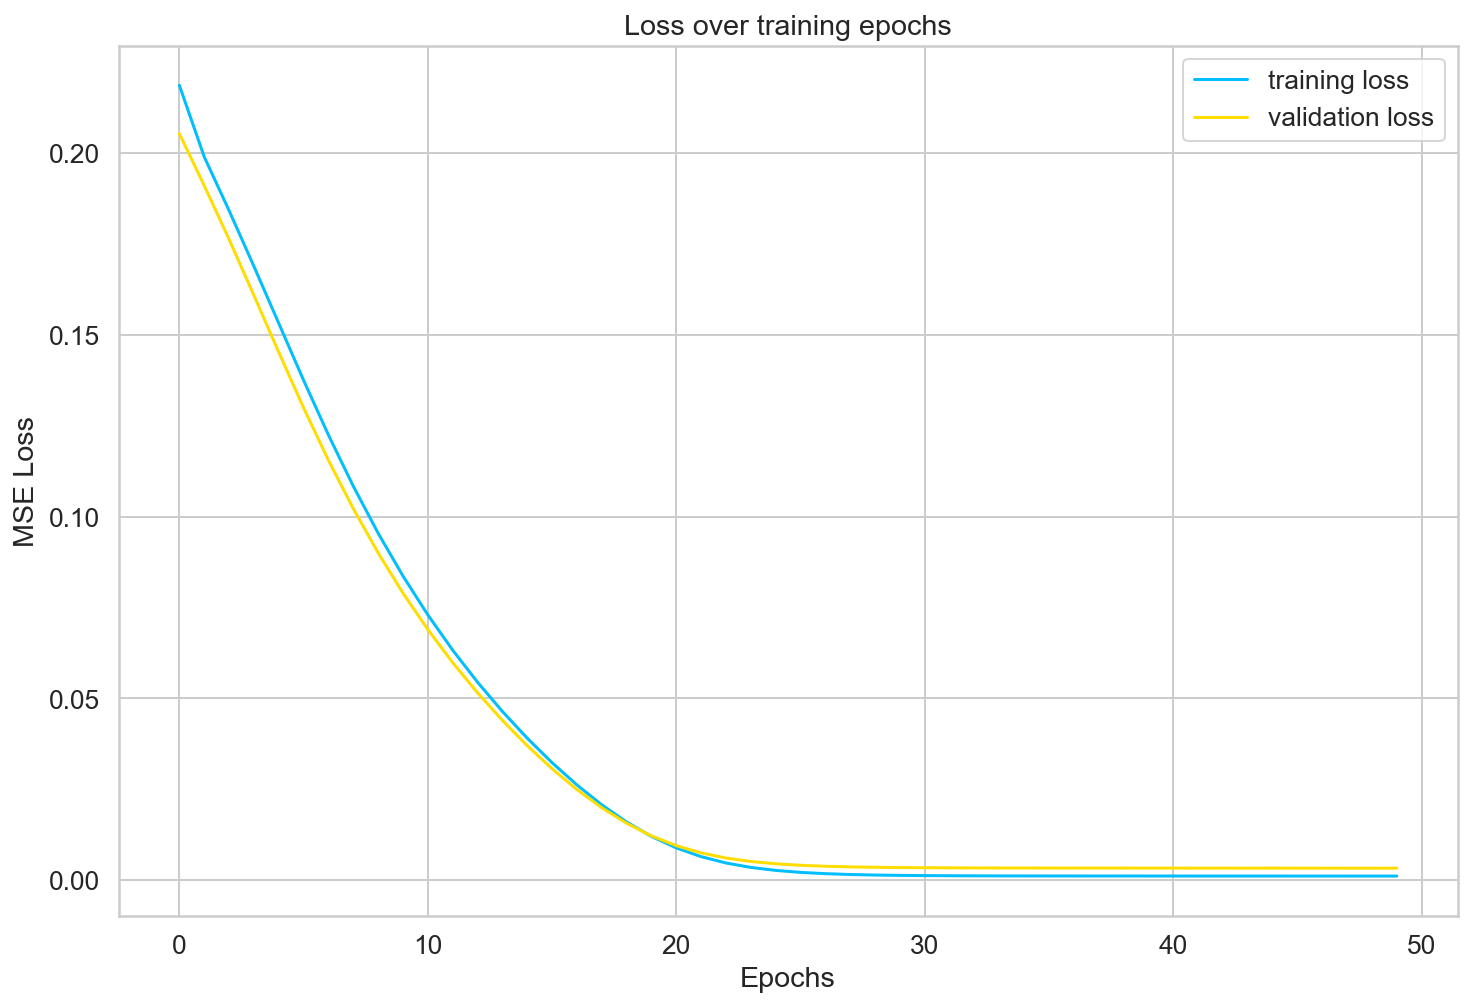

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss over training epochs')
plt.legend(['training loss', 'validation loss'])
plt.show();

### Input vs Reconstruction for a Normal ECG

In [16]:
encoded_imgs = encoder(x_norm_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

In [17]:
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(22,30))
fig.tight_layout()

for i in range(0,10):
    x = np.random.randint(low=0, high=len(x_norm_test))
    plt.subplot(a, b, c)
    plt.plot(x_norm_test[x],'darkblue',)
    plt.plot(decoded_imgs[x],'crimson')
    plt.fill_between(np.arange(140), decoded_imgs[x], x_norm_test[x], color='#F9E79F' )
    plt.title(f'ECG #{x+1}')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    c = c + 1

plt.suptitle('First 10 Normal ECGs from Validation Set - Input, Reconstruction and Error', x=0.32, y=.9, 
             horizontalalignment='left', verticalalignment='bottom', fontweight ="bold")
plt.savefig('images/model_1_norm_in_out.jpg', dpi=300, pad_inches=0.1,)
plt.show()

### Input vs Reconstruction for an Abnormal ECG

In [18]:
encoded_imgs = encoder(x_abnorm_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

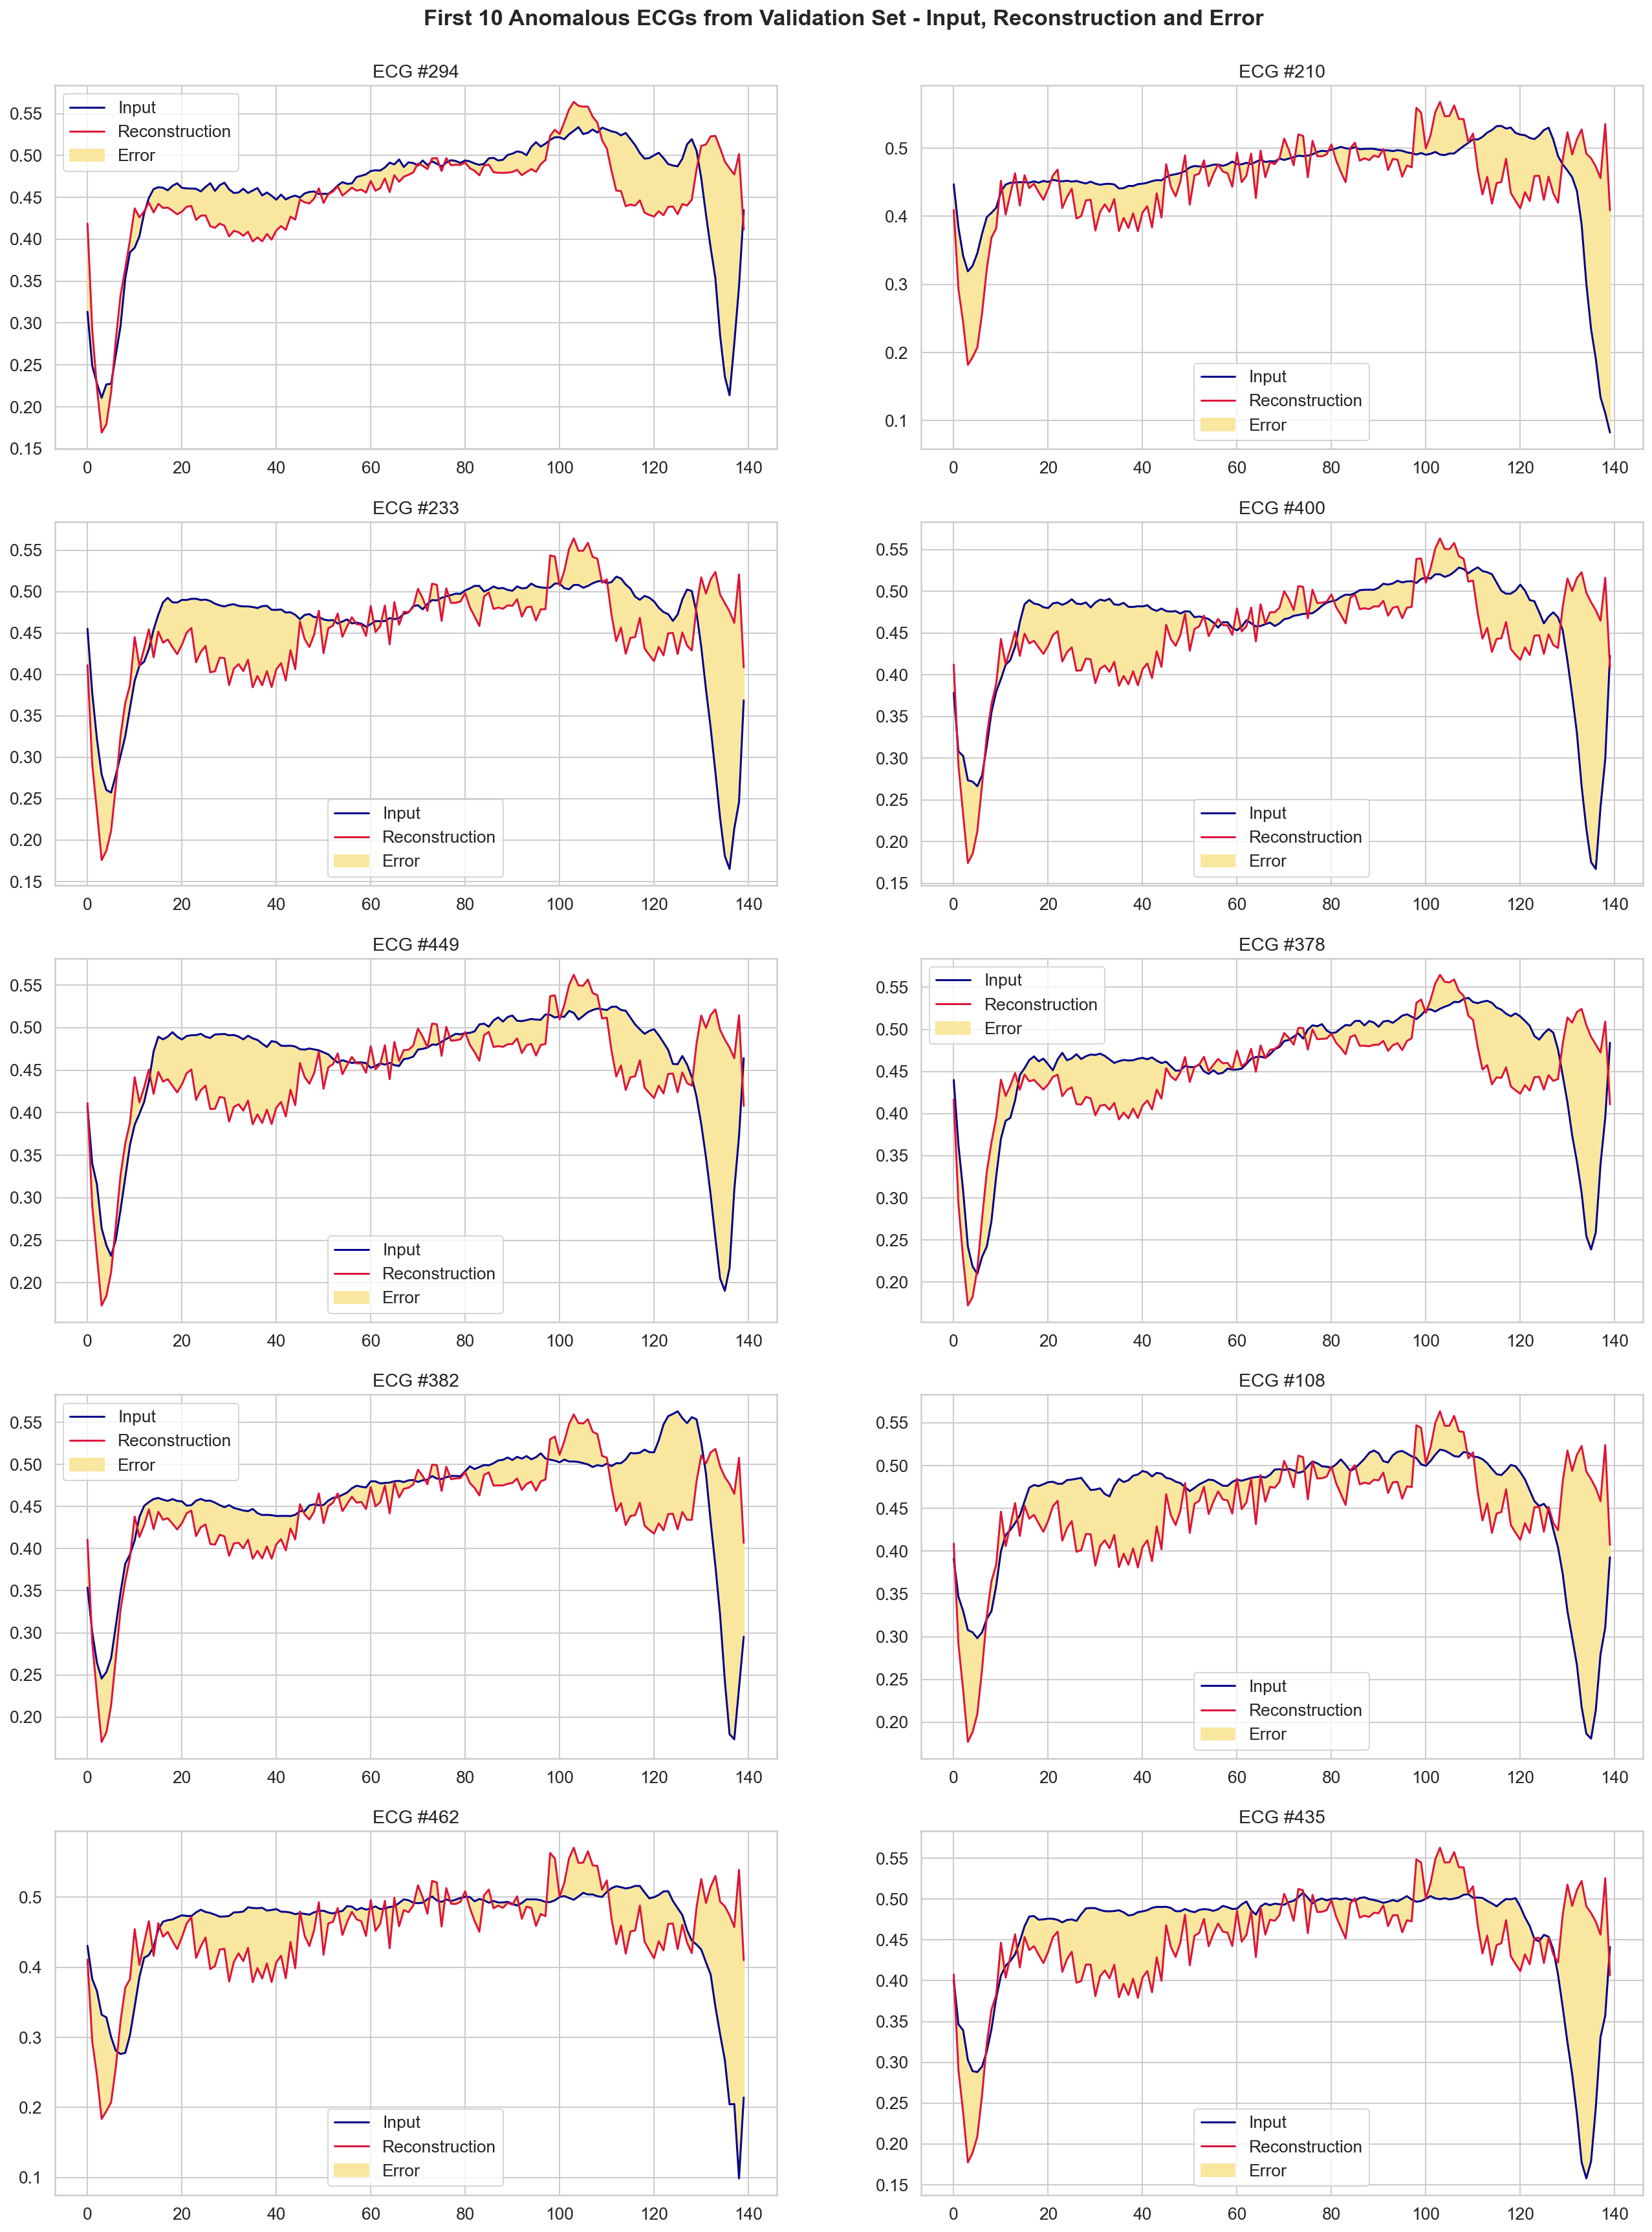

In [19]:
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(22,30))
fig.tight_layout()

for i in range(0,10):
    x = np.random.randint(low=0, high=len(x_abnorm_test))
    plt.subplot(a, b, c)
    plt.plot(x_abnorm_test[x],'darkblue',)
    plt.plot(decoded_imgs[x],'crimson')
    plt.fill_between(np.arange(140), decoded_imgs[x], x_abnorm_test[x], color='#F9E79F' )
    plt.title(f'ECG #{x+1}')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    c = c + 1

plt.suptitle('First 10 Anomalous ECGs from Validation Set - Input, Reconstruction and Error', x=0.305, y=.9, 
             horizontalalignment='left', verticalalignment='bottom', fontweight ="bold")
plt.savefig('images/model_1_abnorm_in_out.jpg', dpi=300, pad_inches=0.1,)
plt.show()

### Finding anomalous ECGs

We are calculating the mean squared error from examples from the normal training set, and then classifying as anomalous examples from the test set where the reconstruction error is 1 standard deviation from the training set.

In [20]:
reconstructions = autoencoder.predict(x_norm_train)
train_loss = tf.keras.losses.mse(reconstructions, x_norm_train)

#plt.hist(train_loss, bins=50)
#plt.xlabel("Train loss")
#plt.ylabel("No of examples")
#plt.show()

In [21]:
reconstructions = autoencoder.predict(x_abnorm_test)
test_loss = tf.keras.losses.mse(reconstructions, x_abnorm_test)

# plt.hist(test_loss, bins=50)
# plt.xlabel("Test loss")
# plt.ylabel("No of examples")
# plt.show()

In [22]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0025112568


In [23]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [24]:
threshold = find_threshold(autoencoder, x_norm_train)
print(f"Threshold: {threshold}")

Threshold: 0.002511256840080023


In [25]:
preds = get_predictions(autoencoder, x_test, threshold)

In [26]:
def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, preds)}")
  print(f"Precision = {precision_score(labels, preds)}")
  print(f"Recall = {recall_score(labels, preds)}")

In [27]:
print_stats(preds, y_test)

Accuracy = 0.9472
Precision = 0.9849624060150376
Recall = 0.9212376933895922


## Model with more layers and activations

In [28]:
encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(4, activation='relu')
    ])

In [29]:
decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(x_norm_train.shape[1], activation='sigmoid')
    ])

In [30]:
model_2 = Sequential([encoder, decoder])

In [31]:
model_2.compile(loss='mae', optimizer='adam')

In [32]:
history = model_2.fit(
    x_norm_train,
    x_norm_train,
    epochs=100,
    batch_size=256,
    validation_data=(x_test, x_test)
)

Epoch 1/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0569 - val_loss: 0.0509
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0456
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0410
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0366 - val_loss: 0.0383
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0372
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0302 - val_loss: 0.0363
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0357
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0351
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.0342
Epoch 10/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0334
Epoch 11/100
9/9 [==========

In [33]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 4)                 11700     
_________________________________________________________________
sequential_4 (Sequential)    (None, 140)               11836     
Total params: 23,536
Trainable params: 23,536
Non-trainable params: 0
_________________________________________________________________


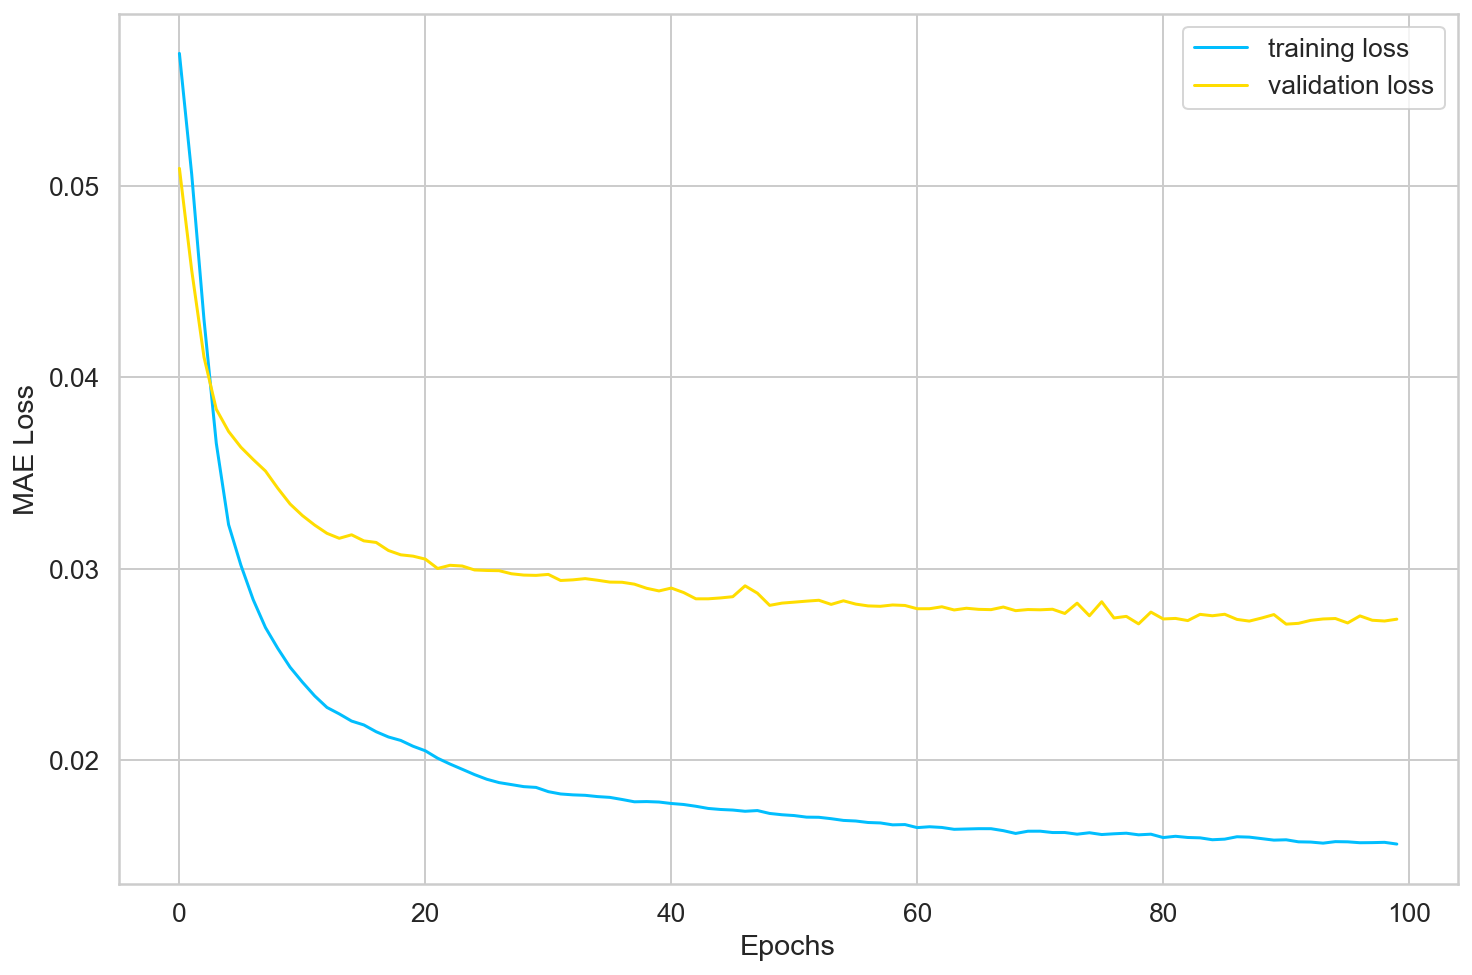

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [35]:
encoded_imgs = encoder(x_norm_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

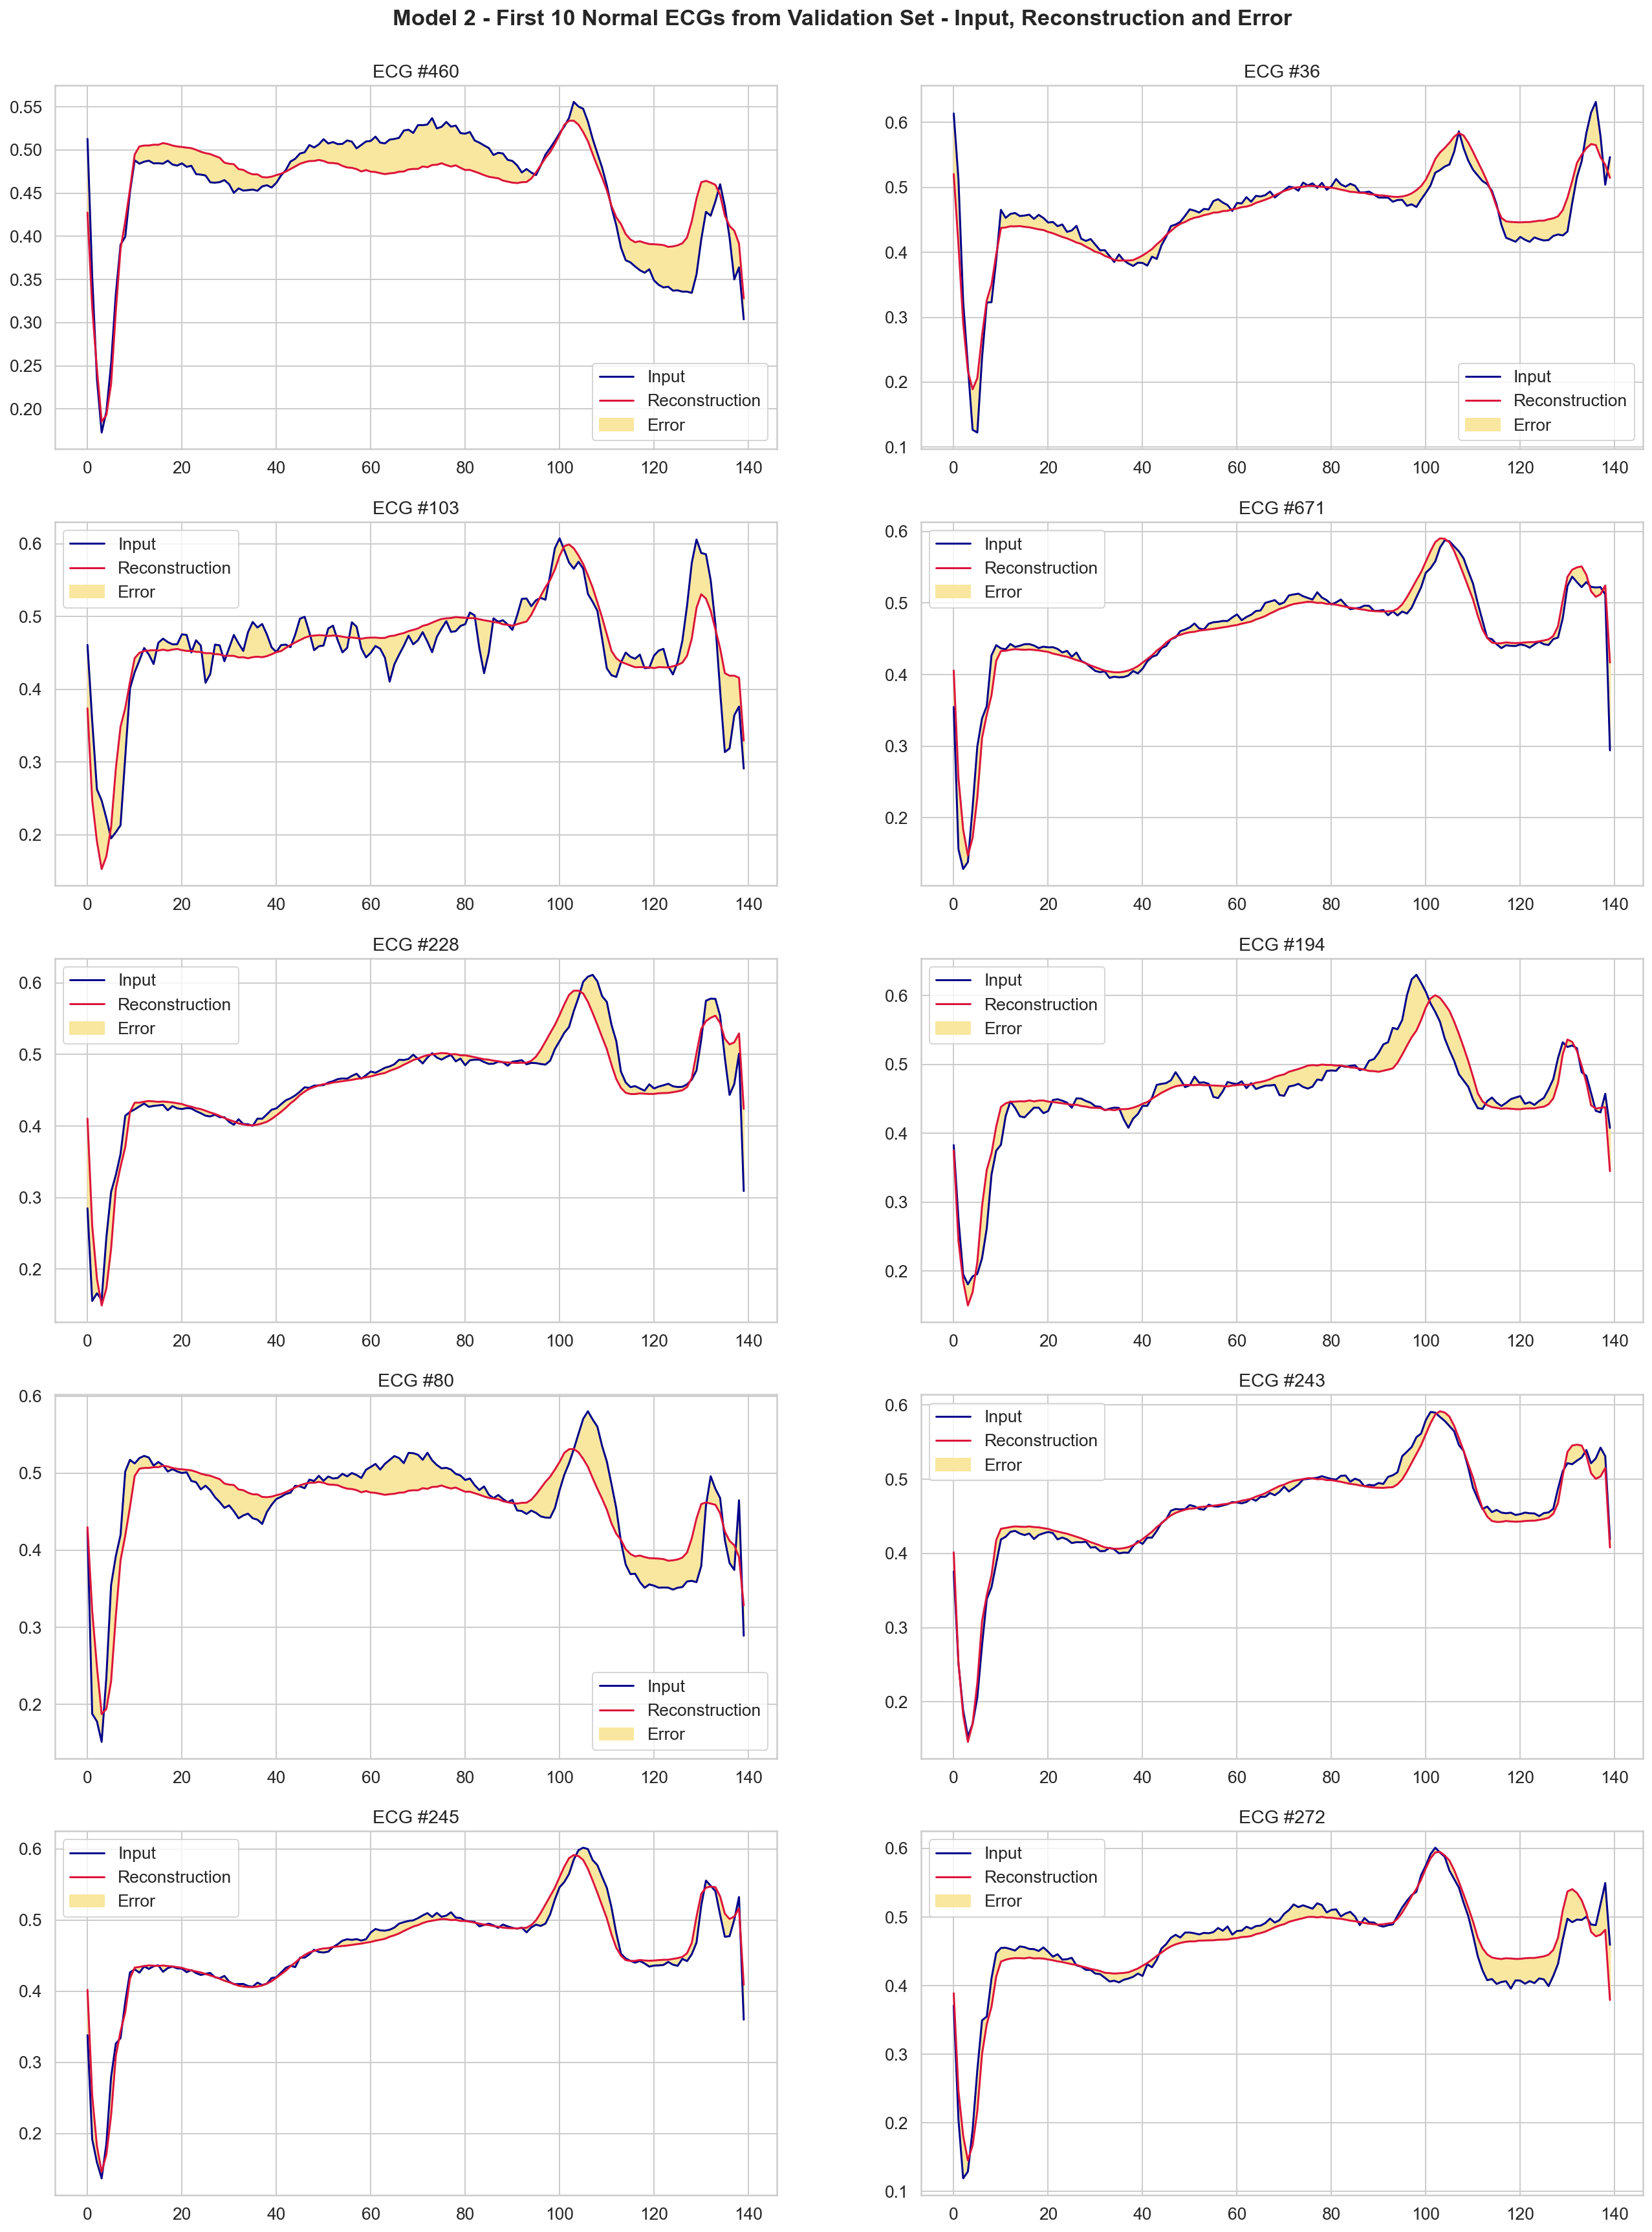

In [36]:
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(22,30))
fig.tight_layout()

for i in range(0,10):
    x = np.random.randint(low=0, high=len(x_norm_test))
    plt.subplot(a, b, c)
    plt.plot(x_norm_test[x],'darkblue',)
    plt.plot(decoded_imgs[x],'crimson')
    plt.fill_between(np.arange(140), decoded_imgs[x], x_norm_test[x], color='#F9E79F' )
    plt.title(f'ECG #{x+1}')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    c = c + 1

plt.suptitle('Model 2 - First 10 Normal ECGs from Validation Set - Input, Reconstruction and Error', x=0.29, y=.9, 
             horizontalalignment='left', verticalalignment='bottom', fontweight ="bold")
plt.savefig('images/model_2_norm_in_out.jpg', dpi=300, pad_inches=0.1,)
plt.show()

In [37]:
encoded_imgs = encoder(x_abnorm_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

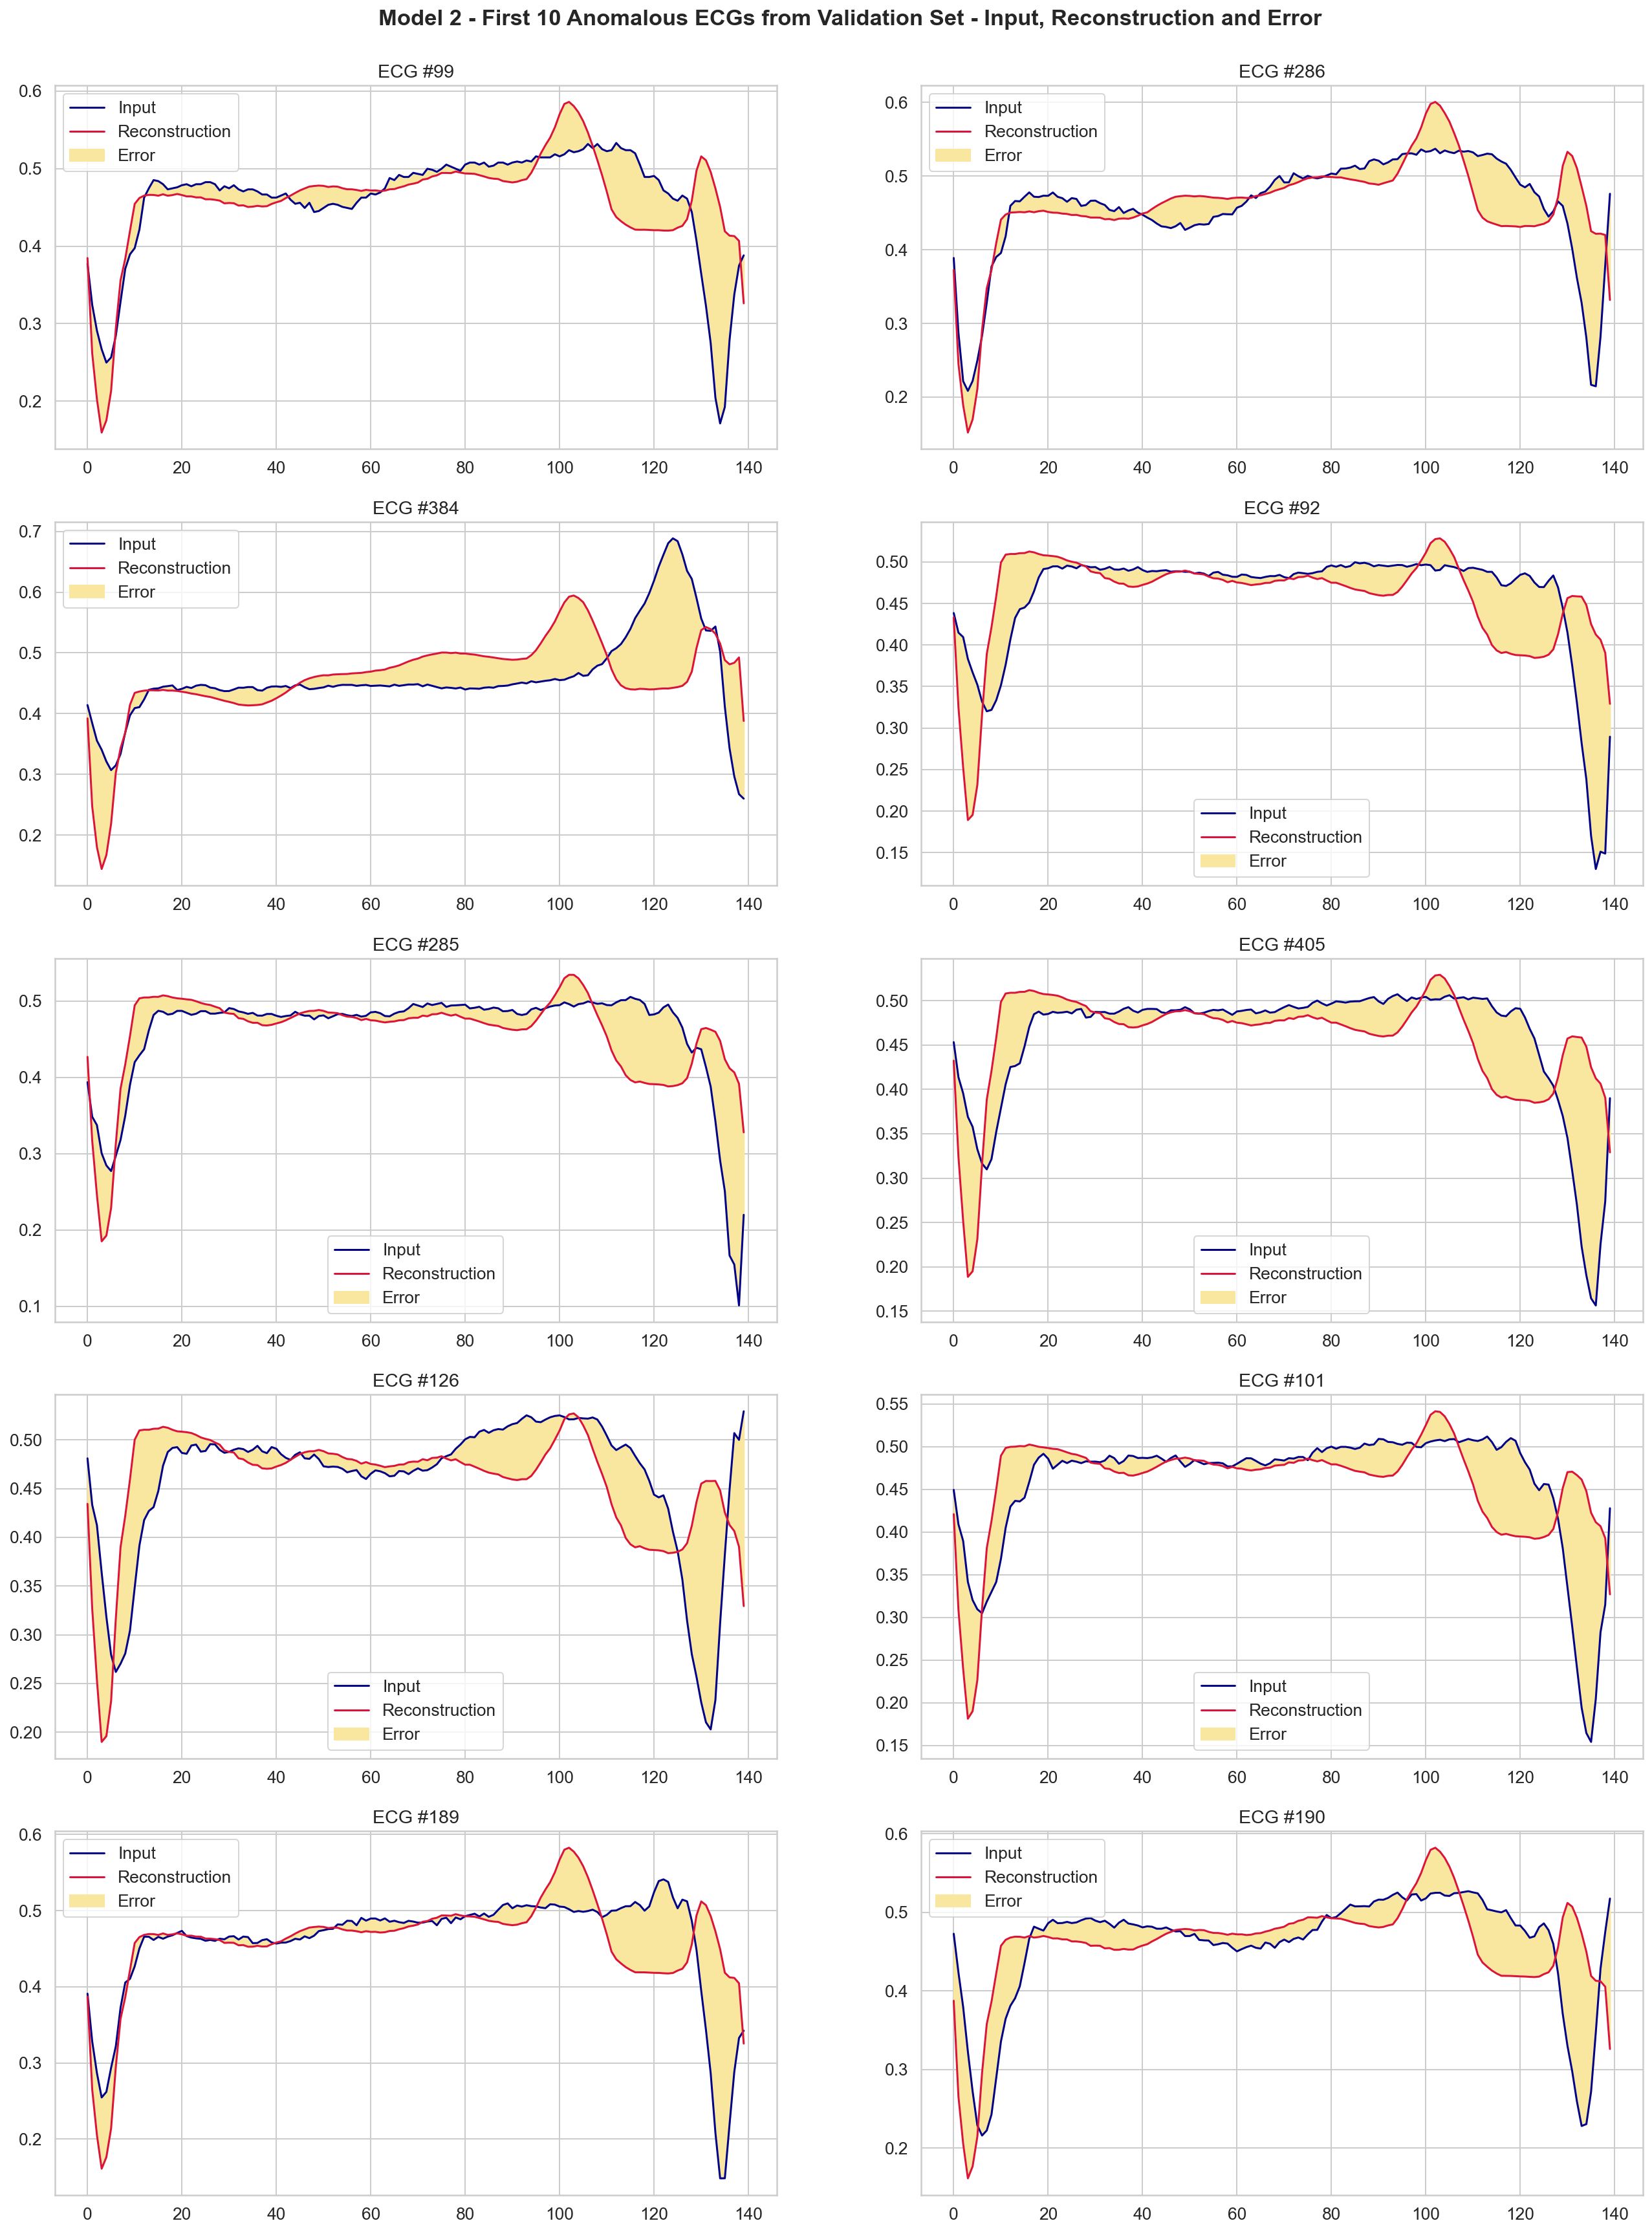

In [38]:
a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(22,30))
fig.tight_layout()

for i in range(0,10):
    x = np.random.randint(low=0, high=len(x_abnorm_test))
    plt.subplot(a, b, c)
    plt.plot(x_abnorm_test[x],'darkblue',)
    plt.plot(decoded_imgs[x],'crimson')
    plt.fill_between(np.arange(140), decoded_imgs[x], x_abnorm_test[x], color='#F9E79F' )
    plt.title(f'ECG #{x+1}')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    c = c + 1

plt.suptitle('Model 2 - First 10 Anomalous ECGs from Validation Set - Input, Reconstruction and Error', x=0.283, y=.9, 
             horizontalalignment='left', verticalalignment='bottom', fontweight ="bold")
plt.savefig('images/model_2_abnorm_in_out.jpg', dpi=300, pad_inches=0.1,)
plt.show()

In [39]:
reconstructions = model_2.predict(x_norm_train)
train_loss = tf.keras.losses.mae(reconstructions, x_norm_train)

#plt.hist(train_loss, bins=50)
#plt.xlabel("Train loss")
#plt.ylabel("No of examples")
#plt.show()

In [40]:
reconstructions = model_2.predict(x_abnorm_test)
test_loss = tf.keras.losses.mae(reconstructions, x_abnorm_test)

# plt.hist(test_loss, bins=50)
# plt.xlabel("Test loss")
# plt.ylabel("No of examples")
# plt.show()

In [41]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02206639


In [42]:
# MAE versions of functions from Model 1

def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.mae(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [43]:
threshold = find_threshold(model_2, x_norm_train)
print(f"Threshold: {threshold}")

Threshold: 0.02206639014184475


In [44]:
preds = get_predictions(model_2, x_test, threshold)

In [45]:
print_stats(preds, y_test)

Accuracy = 0.9256
Precision = 0.9951923076923077
Recall = 0.8734177215189873


## LSTM Autoencoder

In [46]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

NameError: name 'LSTM' is not defined

In [ ]:
!pip

## K-Means

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
!pip install -U keras-tuner

In [ ]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 140)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

In [ ]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)

In [ ]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)